In [2]:
%matplotlib inline
from data_generator import DataGeneratorByGroup
import numpy as np
import matplotlib.pyplot as plt
from brain_utils import plot_brain, plot_source
from scipy.stats import ttest_ind

In [3]:
data = np.load('/home/aulloa/Documents/data/mcic/mcic_smri_data.npy')
labels = np.load('/home/aulloa/Documents/data/mcic/mcic_smri_label.npy')
data.shape

(303, 902629)

In [4]:
#data = np.load('/home/aulloa/mcic_smri_data.npy')
#labels = np.load('/home/aulloa/mcic_smri_label.npy')
mask = (data.mean(axis=0)>0)
data = data[:,mask]
mask = mask.reshape((91,109,91))

print(data.shape)
print(data.dtype)
print(labels.shape)
print(labels.dtype)

(303, 387445)
float64
(303,)
int64


In [5]:
N_components = 20
gen = DataGeneratorByGroup(data-data.mean(),labels,
                           n_components=N_components, n_samples=145,
                           n_batches=1, method='normal')

new_data, label = next(gen)
#new_data[new_data<0]=0
#new_data[new_data>1]=1

INFO:data_generator.generator:Classes: [0 1]


Step 85: Lrate 2.7e-07,Wchange 9.4e-07,Angle 91.33


In [7]:
print(new_data.shape)
print(label)

(290, 387445)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


        Healthy /      Patient
-0.062 +- 0.006 / -0.061 +- 0.007
-0.108 +- 0.008 / -0.103 +- 0.009
-0.011 +- 0.005 / -0.009 +- 0.004
-0.003 +- 0.005 / -0.002 +- 0.006
-0.013 +- 0.005 / -0.013 +- 0.004
-0.104 +- 0.007 / -0.096 +- 0.010
-0.031 +- 0.005 / -0.030 +- 0.005
-0.149 +- 0.005 / -0.148 +- 0.005
-0.057 +- 0.004 / -0.058 +- 0.005
 0.069 +- 0.009 /  0.062 +- 0.010
 0.037 +- 0.005 /  0.037 +- 0.006
-0.024 +- 0.008 / -0.023 +- 0.009
 0.036 +- 0.005 /  0.032 +- 0.006
 0.009 +- 0.004 /  0.009 +- 0.005
 0.026 +- 0.005 /  0.024 +- 0.005
 0.019 +- 0.005 /  0.016 +- 0.007
 0.073 +- 0.009 /  0.069 +- 0.011
-0.074 +- 0.007 / -0.073 +- 0.007
 0.022 +- 0.007 /  0.021 +- 0.007
-0.037 +- 0.010 / -0.034 +- 0.010


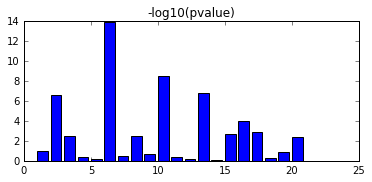

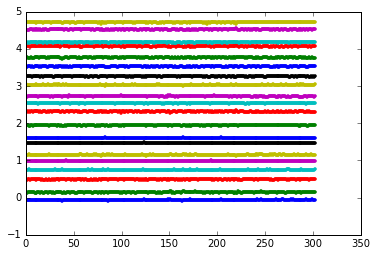

In [8]:
# mixing matrix

plt.figure(figsize=(6,2.5))
result = ttest_ind(gen.mixing[labels==0,:], gen.mixing[labels==1,:])
plt.bar(np.arange(N_components)+1, height = -np.log10(result.pvalue))
plt.title('-log10(pvalue)')

#plt.figure(figsize=(12,10))
#plt.imshow(gen.mixing, aspect=.08, interpolation='none')
#plt.colorbar()
plt.figure()
print('{:>15} / {:>12}'.format('Healthy', 'Patient'))
for i in range(N_components):
    plt.plot(gen.mixing[:,i]+i/4,'.')
    hc_mean = gen.mixing[labels==0,i].mean()
    hc_std = gen.mixing[labels==0,i].std()
    sz_mean = gen.mixing[labels==1,i].mean()
    sz_std = gen.mixing[labels==1,i].std()
    print('{hc_mean:>6.3f} +- {hc_std:.3f} / {sz_mean:>6.3f} +- {sz_std:.3f}'.format(**locals()))
    

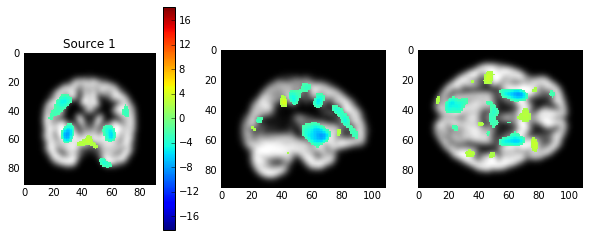

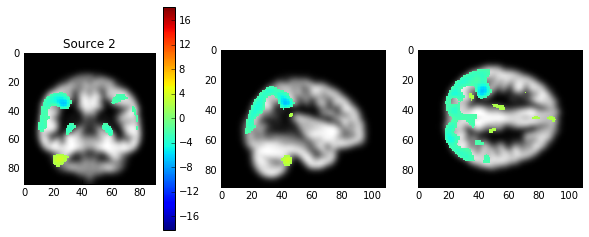

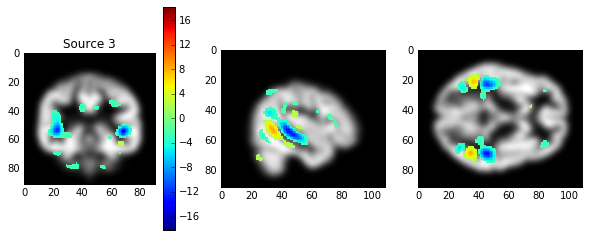

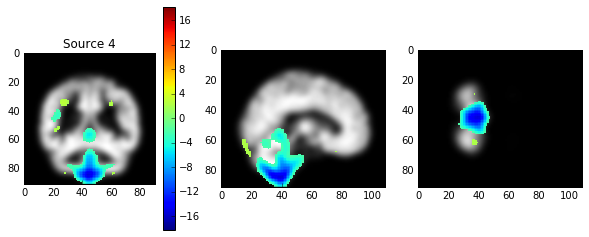

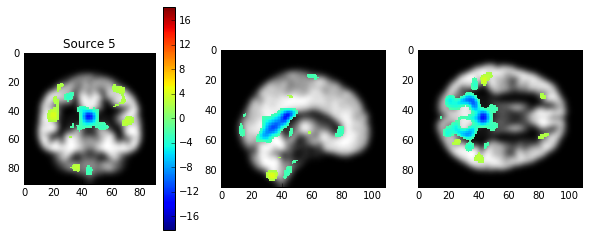

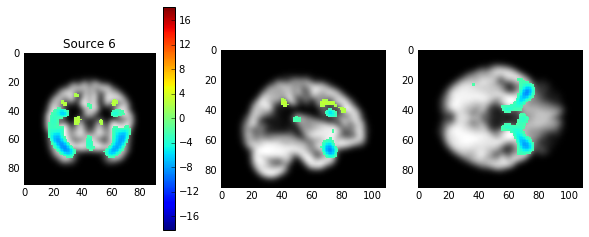

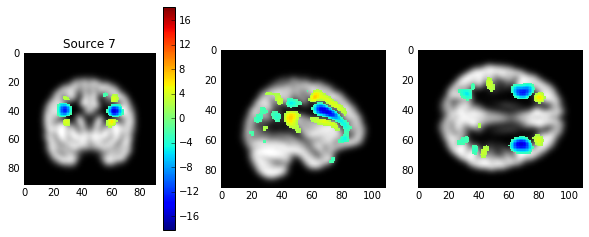

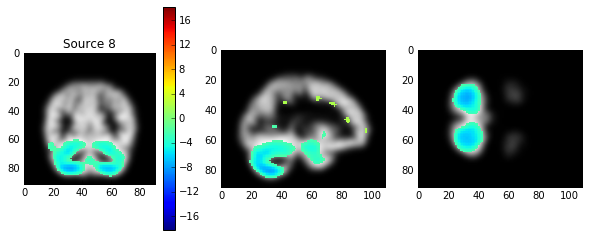

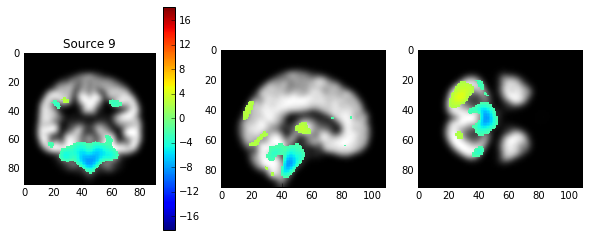

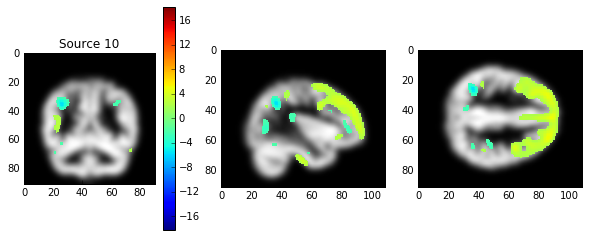

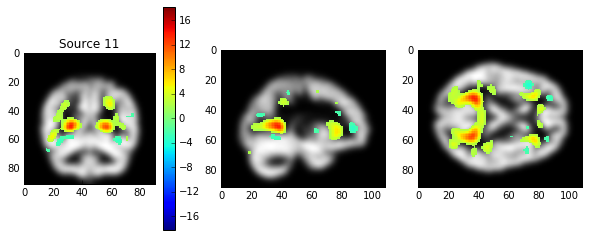

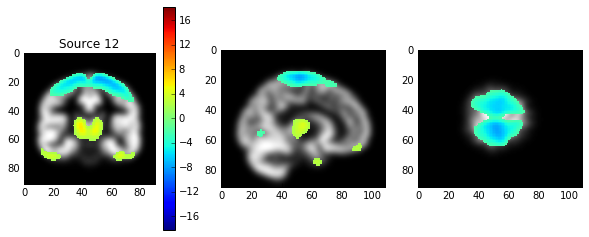

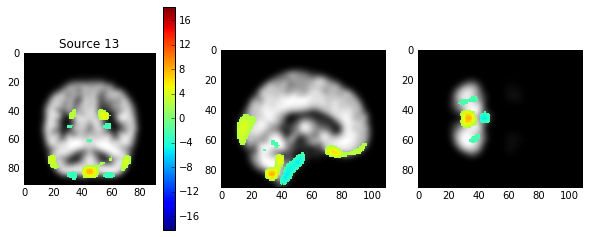

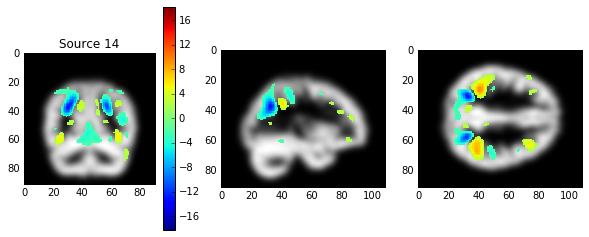

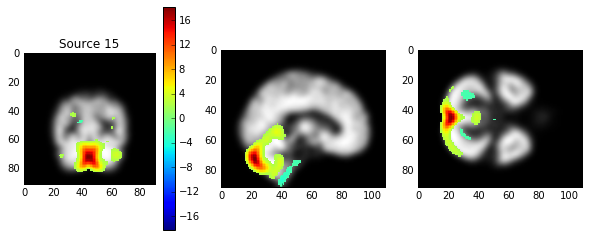

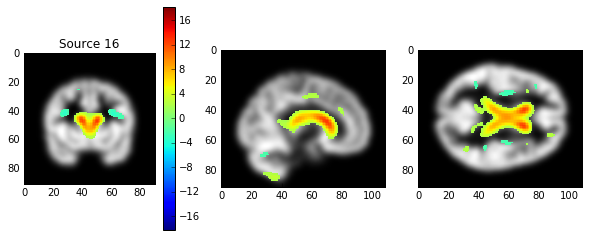

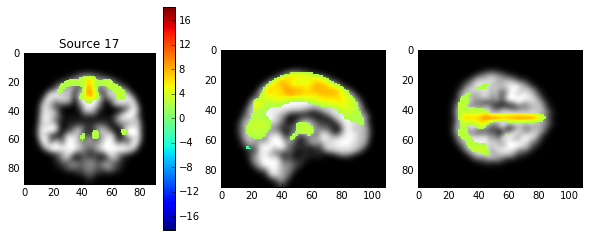

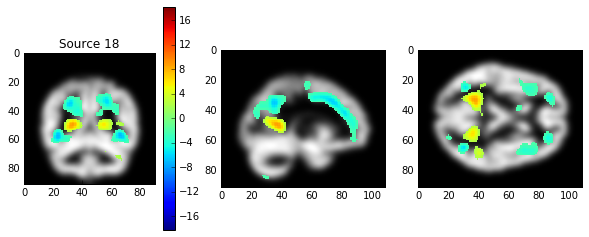

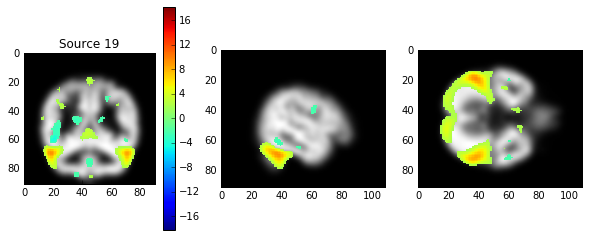

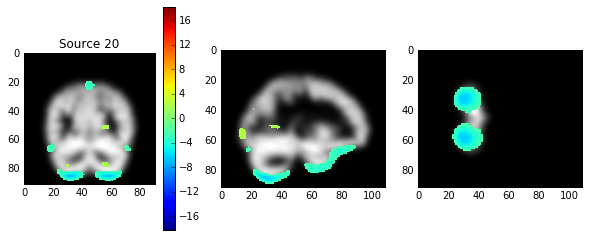

In [9]:
#sources 
vmax=np.abs(gen.sources).max()
vmin=-vmax
#vmin=-10
#vmax=10
for n,source in enumerate(gen.sources):
    #plt.subplot(10,1,n+1)
    plt.figure(figsize=(10,4))
    plot_source(source, data[0,:], mask, 2, vmin=vmin, vmax=vmax)
    plt.subplot(1,3,1)
    plt.title('Source %d'%(n+1))
    plt.colorbar()

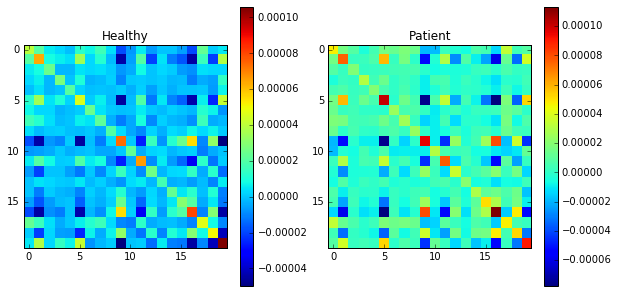

In [11]:
# Covariance
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gen.params['cov'][0],
          interpolation='nearest')
plt.colorbar()
plt.title('Healthy')
plt.subplot(1,2,2)
plt.imshow(gen.params['cov'][1],
          interpolation='nearest')
plt.colorbar()
plt.title('Patient')

# Sparse Covariance

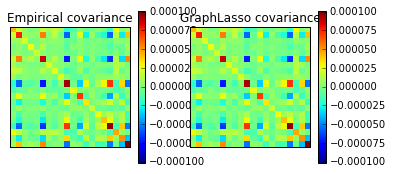

In [12]:
from sklearn.covariance import GraphLassoCV, ledoit_wolf
from scipy import linalg

X = gen.mixing - gen.mixing.mean(axis=0)
n_samples = X.shape[0]
##############################################################################
# Estimate the covariance
emp_cov = np.dot(X.T, X) / (n_samples-1)

model = GraphLassoCV(alphas=list(np.arange(10)*1e-3))
model.fit(X)
cov_ = model.covariance_

##############################################################################
# Plot the results
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical', emp_cov), ('GraphLasso', cov_)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)
    plt.colorbar()


# Average original data vs fake data

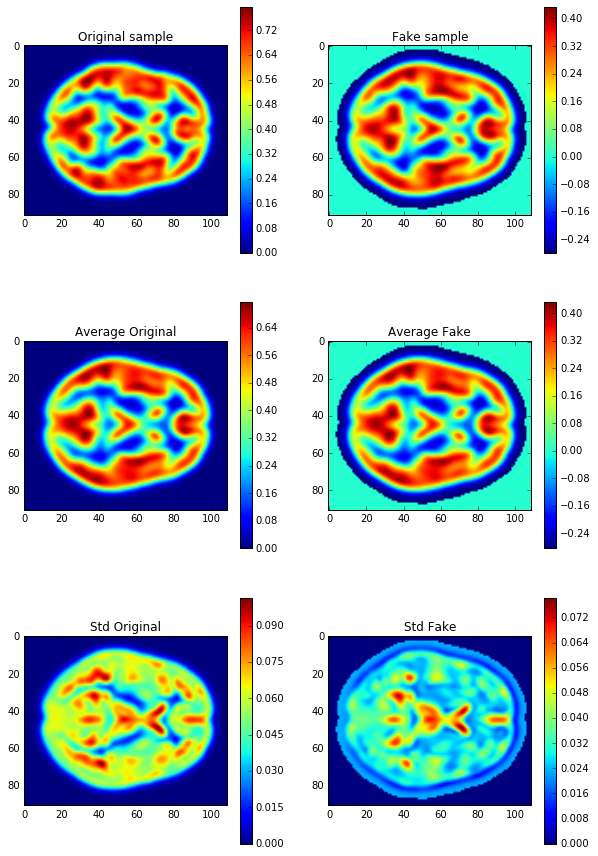

In [13]:
plt.figure(figsize=(10,15))
plt.subplot(3,2,1)
plot_brain(data[1,:], mask)
plt.title('Original sample')
plt.subplot(3,2,2)
plot_brain(new_data[1,:], mask)
plt.title('Fake sample')

plt.subplot(3,2,3)
plot_brain(data.mean(axis=0), mask)
plt.title('Average Original')
plt.subplot(3,2,4)
plot_brain(new_data.mean(axis=0), mask)
plt.title('Average Fake')

plt.subplot(3,2,5)
plot_brain(data.std(axis=0), mask)
plt.title('Std Original')
plt.subplot(3,2,6)
plot_brain(new_data.std(axis=0), mask)
plt.title('Std Fake')

0.289229043135
0.24792384854
0.275284169521
0.239295986979


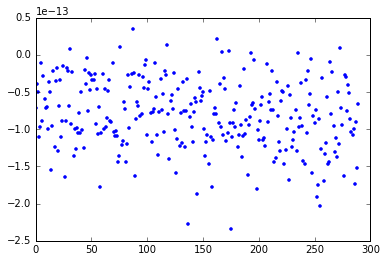

In [14]:
plt.plot(new_data.mean(axis=1),'.')

print(data[labels==0,:].mean())
print(data[labels==0,:].std())
print(data[labels==1,:].mean())
print(data[labels==1,:].std())


In [ ]:
np.save('/home/aulloa/Documents/data/fake_smri.npy', new_data)

In [ ]:
np.save('/home/aulloa/Documents/data/fake_labels.npy',np.array([0]*1000 + [1]*1000))